In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
from IPython.display import Audio, display
from scipy import signal

---

# Load LibriMix Dataset

In [2]:
# dataset configuration (specified upon creating LibriMix)
ROOT_DIR = '../data/Libri2Mix'
SAMPLE_RATE = '16k'
N_SRC = 2
MODE = 'min'

# display settings
SPLIT = 'train'  # 'train', 'dev', or 'test'
MIXTURE_TYPE = 'mix_both' # 'mix_clean', 'mix_both', or 'mix_single'
SAMPLE_IDX = 0 # sample index to load

print(f"Dataset: {ROOT_DIR}")
print(f"Configuration: {SAMPLE_RATE}, {N_SRC} sources, {MODE} mode")
print(f"Loading: {SPLIT} / {MIXTURE_TYPE} / sample {SAMPLE_IDX}")

Dataset: ../data/Libri2Mix
Configuration: 16k, 2 sources, min mode
Loading: train / mix_both / sample 0


---
# Dataset Statistics

Dataset Statistics: train / mix_both
Total samples: 13900
Mean duration: 11.21 seconds
Std duration: 3.60 seconds
Min duration: 3.00 seconds
Max duration: 16.60 seconds


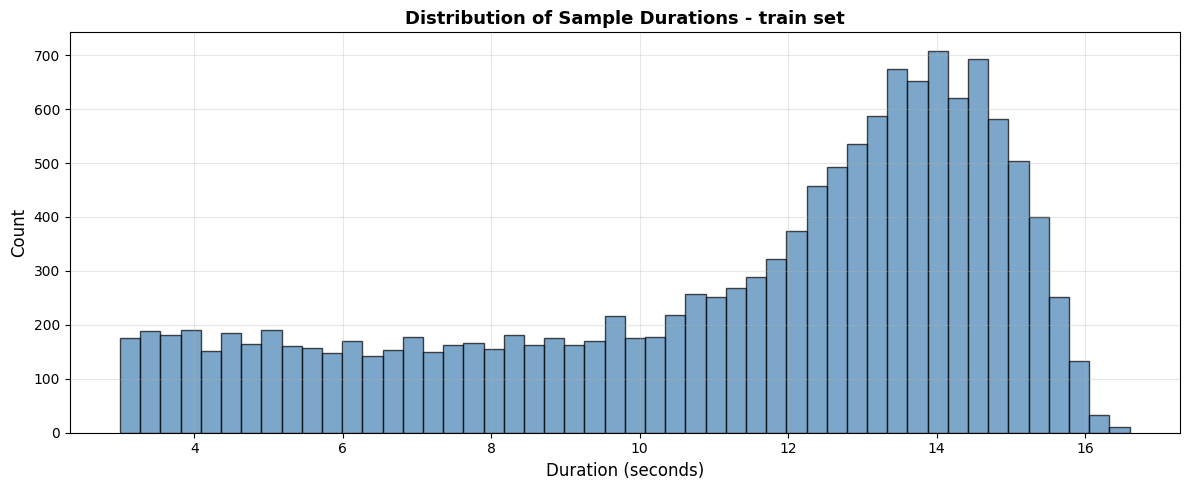

In [3]:
# get dataset statistics
split_map = {'train': 'train-100', 'dev': 'dev', 'test': 'test'}
split_dir = split_map.get(SPLIT, SPLIT)

metadata_path = os.path.join(ROOT_DIR, f'wav{SAMPLE_RATE}', MODE, 'metadata', f'mixture_{split_dir}_{MIXTURE_TYPE}.csv')

metadata = pd.read_csv(metadata_path)
fs = int(SAMPLE_RATE.replace('k', '')) * 1000

print(f"Dataset Statistics: {SPLIT} / {MIXTURE_TYPE}")
print("="*60)
print(f"Total samples: {len(metadata)}")
print(f"Mean duration: {metadata['length'].mean() / fs:.2f} seconds")
print(f"Std duration: {metadata['length'].std() / fs:.2f} seconds")
print(f"Min duration: {metadata['length'].min() / fs:.2f} seconds")
print(f"Max duration: {metadata['length'].max() / fs:.2f} seconds")

# plot duration distribution
plt.figure(figsize=(12, 5))
durations = metadata['length'] / fs
plt.hist(durations, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Distribution of Sample Durations - {SPLIT} set', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# load LibriSpeech speaker metadata
librispeech_metadata_dir = f"{ROOT_DIR}/wav{SAMPLE_RATE}/{MODE}/metadata/LibriSpeech"

# load all speaker metadata files
speaker_lookup = {}

for csv_file in ['dev-clean.csv', 'test-clean.csv', 'train-clean-100.csv']:
    csv_path = os.path.join(librispeech_metadata_dir, csv_file)
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # Create lookup: speaker_ID -> sex
        for _, row in df.iterrows():
            speaker_lookup[int(row['speaker_ID'])] = row['sex']

print(f"Loaded metadata for {len(speaker_lookup)} speakers")
print(f"\nSample speakers:")
for speaker_id, sex in list(speaker_lookup.items())[:5]:
    print(f"  Speaker {speaker_id}: {sex}")

Loaded metadata for 331 speakers

Sample speakers:
  Speaker 6295: M
  Speaker 6313: F
  Speaker 1462: F
  Speaker 2277: F
  Speaker 174: M


In [5]:
# analyze gender pairing distribution in dataset
metadata_path = f"{ROOT_DIR}/wav{SAMPLE_RATE}/{MODE}/metadata/mixture_{SPLIT.replace('train', 'train-100')}_{MIXTURE_TYPE}.csv"
metadata = pd.read_csv(metadata_path)

pairings = {'M-M': 0, 'M-F': 0, 'F-M': 0, 'F-F': 0}

for _, row in metadata.iterrows():
    mixture_id = row['mixture_ID']
    parts = mixture_id.split('_')
    
    genders = []
    for part in parts:
        speaker_id = int(part.split('-')[0])
        gender = speaker_lookup.get(speaker_id, 'U')
        genders.append(gender)
    
    pairing = f"{genders[0]}-{genders[1]}"
    if pairing in pairings:
        pairings[pairing] += 1

print("Gender Pairing Distribution:")
print("="*50)
total = sum(pairings.values())
for pairing, count in pairings.items():
    pct = 100 * count / total
    print(f"{pairing}: {count:>4} ({pct:>5.1f}%)")

Gender Pairing Distribution:
M-M: 3441 ( 24.8%)
M-F: 3437 ( 24.7%)
F-M: 3539 ( 25.5%)
F-F: 3483 ( 25.1%)


---
# Inspect Single Sample

In [6]:
# helper functions for loading
def normalize_path(root_dir, stored_path):
    """Convert stored path to correct local path"""
    stored_path = str(stored_path)
    
    # if path is already absolute and exists, use it
    if os.path.isabs(stored_path) and os.path.exists(stored_path):
        return stored_path
    
    # remove Libri2Mix or Libri3Mix prefix if present
    if 'Libri2Mix/' in stored_path:
        rel_path = stored_path.split('Libri2Mix/', 1)[1]
    elif 'Libri3Mix/' in stored_path:
        rel_path = stored_path.split('Libri3Mix/', 1)[1]
    else:
        rel_path = stored_path
    
    return os.path.join(root_dir, rel_path)


def load_sample(root_dir, split, mixture_type, idx, sample_rate='16k', n_src=2, mode='min'):
    """Load a sample from the dataset"""
    split_map = {'train': 'train-100', 'dev': 'dev', 'test': 'test'}
    split_dir = split_map.get(split, split)
    
    # load metadata
    metadata_path = os.path.join(
        root_dir, f'wav{sample_rate}', mode, 'metadata',
        f'mixture_{split_dir}_{mixture_type}.csv'
    )
    
    metadata = pd.read_csv(metadata_path)
    row = metadata.iloc[idx]
    
    # load mixture
    mixture_path = normalize_path(root_dir, row['mixture_path'])
    mixture, fs = sf.read(mixture_path)
    
    # load sources
    sources = []
    for i in range(n_src):
        source_path = normalize_path(root_dir, row[f'source_{i+1}_path'])
        source, _ = sf.read(source_path)
        sources.append(source)
    sources = np.array(sources)
    
    result = {
        'mixture': mixture,
        'sources': sources,
        'mixture_id': row['mixture_ID'],
        'sample_rate': fs,
        'metadata': row
    }
    
    # load noise if applicable
    if mixture_type in ['mix_both', 'mix_single']:
        noise_path = normalize_path(root_dir, row['noise_path'])
        noise, _ = sf.read(noise_path)
        result['noise'] = noise

    # load metrics if available
    metrics_path = metadata_path.replace('mixture_', 'metrics_')
    if os.path.exists(metrics_path):
        metrics_df = pd.read_csv(metrics_path)
        sample_metrics = metrics_df[metrics_df['mixture_ID'] == row['mixture_ID']]
        
        if len(sample_metrics) > 0:
            metrics_row = sample_metrics.iloc[0]
            result['metrics'] = {
                'source_1_snr': metrics_row['source_1_SNR'],
                'source_2_snr': metrics_row['source_2_SNR'],
            }
            if 'noise_SNR' in metrics_row and pd.notna(metrics_row['noise_SNR']):
                result['metrics']['noise_snr'] = metrics_row['noise_SNR']
    
    return result

In [7]:
# load specified sample
sample = load_sample(ROOT_DIR, SPLIT, MIXTURE_TYPE, SAMPLE_IDX, SAMPLE_RATE, N_SRC, MODE)

print(f"Single sample summary:\n")
print(f"Sample ID: {sample['mixture_id']}")
print(f"Sample rate: {sample['sample_rate']} Hz")
print(f"Duration: {len(sample['mixture']) / sample['sample_rate']:.2f} seconds")
print(f"Number of sources: {N_SRC}")
print(f"Mixture type: {MIXTURE_TYPE}")
print(f"Mixture shape: {sample['mixture'].shape}")
print(f"Sources shape: {sample['sources'].shape}")
if 'noise' in sample:
    print(f"Noise shape: {sample['noise'].shape}")

print(f"\nSignal-to-Noise Ratio (SNR):")
for i in range(sample['sources'].shape[0]):
    source = sample['sources'][i]
    interference = sample['mixture'] - source
    
    source_power = np.mean(source ** 2)
    interference_power = np.mean(interference ** 2)
    
    snr_computed = 10 * np.log10(source_power / (interference_power + 1e-10))
    snr_metrics = sample['metrics'][f'source_{i+1}_snr']
    
    print(f"\nSource {i+1} vs Interference:")
    print(f"  From metadata: {snr_metrics:.2f} dB")
    print(f"  Computed: {snr_computed:.2f} dB")

if 'noise' in sample:
    speech = np.sum(sample['sources'], axis=0)
    noise = sample['noise']
    
    speech_power = np.mean(speech ** 2)
    noise_power = np.mean(noise ** 2)
    
    snr_computed = 10 * np.log10(speech_power / (noise_power + 1e-10))
    snr_metrics = sample['metrics']['noise_snr']
    
    print(f"\nSpeech vs Noise (signs are opposite: speech perspective vs noise perspective):")
    print(f"  Noise/Speech (metadata): {snr_metrics:.2f} dB")
    print(f"  Speech/Noise (computed): {snr_computed:.2f} dB")

Single sample summary:

Sample ID: 1578-6379-0038_6415-111615-0009
Sample rate: 16000 Hz
Duration: 6.70 seconds
Number of sources: 2
Mixture type: mix_both
Mixture shape: (107120,)
Sources shape: (2, 107120)
Noise shape: (107120,)

Signal-to-Noise Ratio (SNR):

Source 1 vs Interference:
  From metadata: -0.12 dB
  Computed: -0.12 dB

Source 2 vs Interference:
  From metadata: -1.71 dB
  Computed: -1.71 dB

Speech vs Noise (signs are opposite: speech perspective vs noise perspective):
  Noise/Speech (metadata): -9.38 dB
  Speech/Noise (computed): 9.38 dB


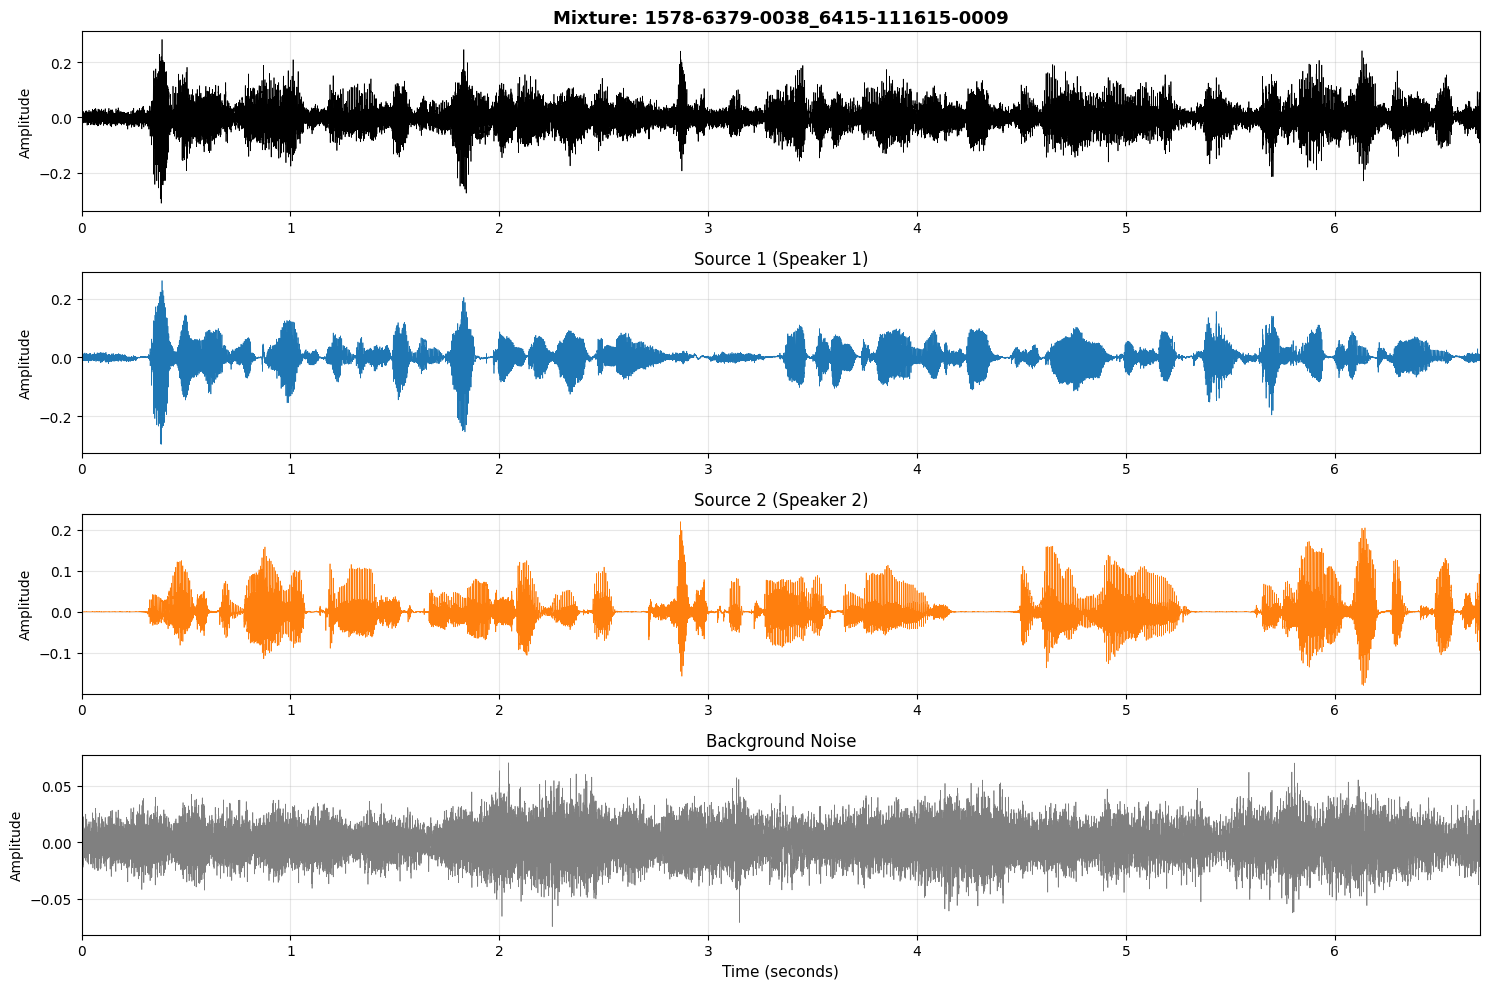

In [8]:
# plot waveforms
fs = sample['sample_rate']
time = np.arange(len(sample['mixture'])) / fs

n_plots = 1 + N_SRC
if 'noise' in sample:
    n_plots += 1

fig, axes = plt.subplots(n_plots, 1, figsize=(15, 2.5*n_plots))
if n_plots == 1:
    axes = [axes]

# plot mixture
axes[0].plot(time, sample['mixture'], linewidth=0.5, color='black')
axes[0].set_title(f"Mixture: {sample['mixture_id']}", fontsize=13, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, time[-1]])

# plot sources
for i in range(N_SRC):
    axes[i+1].plot(time, sample['sources'][i], linewidth=0.5, color=f'C{i}')
    axes[i+1].set_title(f"Source {i+1} (Speaker {i+1})", fontsize=12)
    axes[i+1].set_ylabel('Amplitude')
    axes[i+1].grid(True, alpha=0.3)
    axes[i+1].set_xlim([0, time[-1]])

# plot noise if present
if 'noise' in sample:
    axes[-1].plot(time, sample['noise'], linewidth=0.5, color='gray')
    axes[-1].set_title("Background Noise", fontsize=12)
    axes[-1].set_ylabel('Amplitude')
    axes[-1].grid(True, alpha=0.3)
    axes[-1].set_xlim([0, time[-1]])

axes[-1].set_xlabel('Time (seconds)', fontsize=11)

plt.tight_layout()
plt.show()

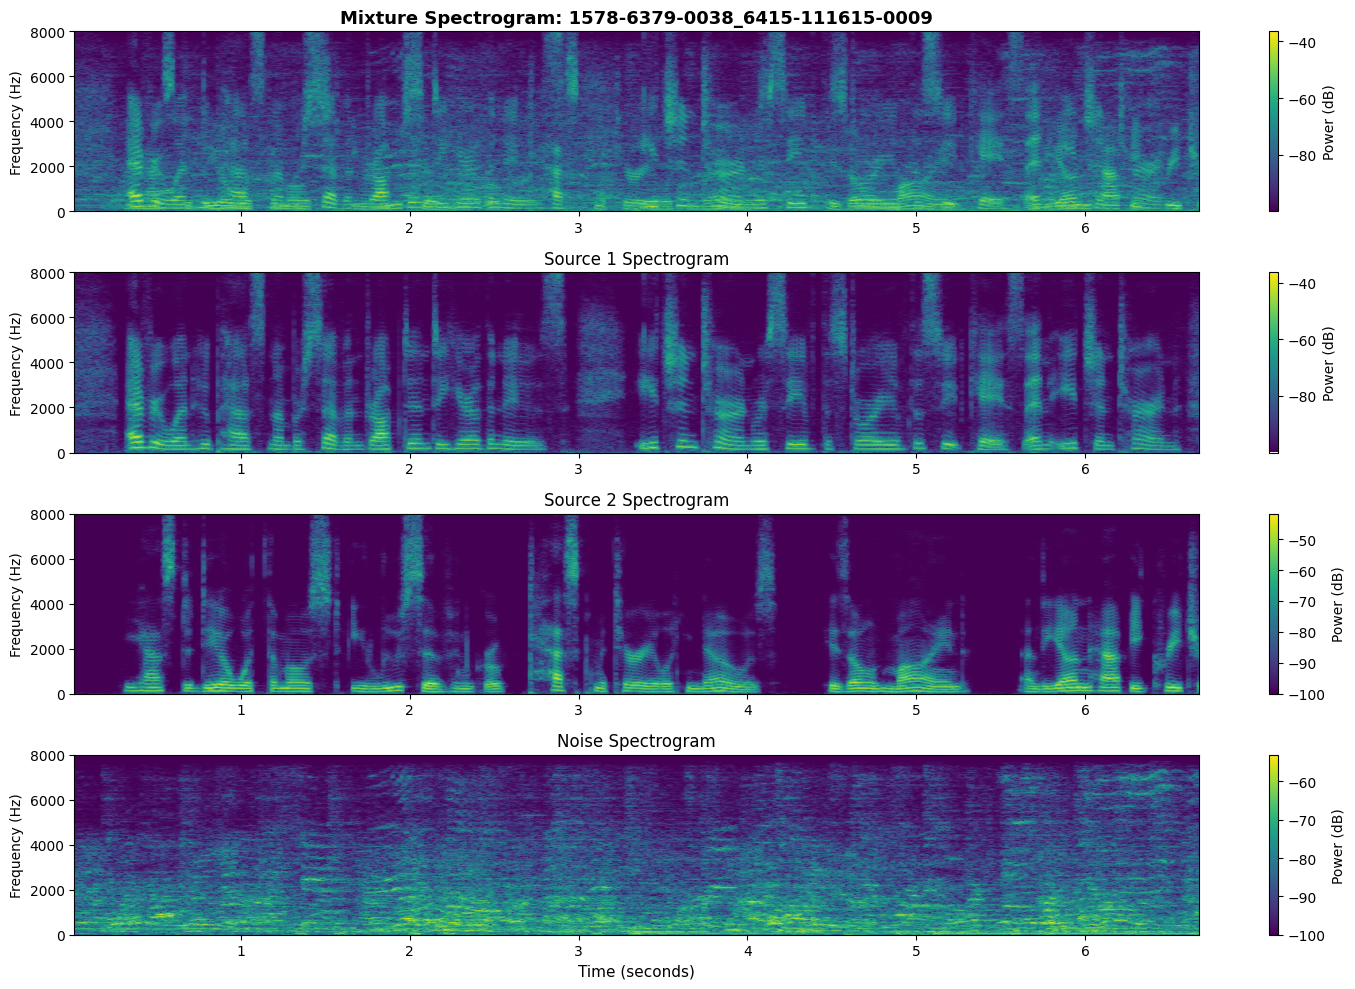

In [9]:
# plot spectrograms
fs = sample['sample_rate']
nperseg = 512
noverlap = 384

n_plots = 1 + N_SRC
if 'noise' in sample:
    n_plots += 1

fig, axes = plt.subplots(n_plots, 1, figsize=(15, 2.5*n_plots))
if n_plots == 1:
    axes = [axes]

# mixture spectrogram
f, t, Sxx = signal.spectrogram(sample['mixture'], fs, nperseg=nperseg, noverlap=noverlap)
im = axes[0].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
axes[0].set_title(f"Mixture Spectrogram: {sample['mixture_id']}", fontsize=13, fontweight='bold')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_ylim([0, fs // 2])
plt.colorbar(im, ax=axes[0], label='Power (dB)')

# source spectrograms
for i in range(N_SRC):
    f, t, Sxx = signal.spectrogram(sample['sources'][i], fs, nperseg=nperseg, noverlap=noverlap)
    im = axes[i+1].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    axes[i+1].set_title(f"Source {i+1} Spectrogram", fontsize=12)
    axes[i+1].set_ylabel('Frequency (Hz)')
    axes[i+1].set_ylim([0, fs // 2])
    plt.colorbar(im, ax=axes[i+1], label='Power (dB)')

# noise spectrogram
if 'noise' in sample:
    f, t, Sxx = signal.spectrogram(sample['noise'], fs, nperseg=nperseg, noverlap=noverlap)
    im = axes[-1].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    axes[-1].set_title("Noise Spectrogram", fontsize=12)
    axes[-1].set_ylabel('Frequency (Hz)')
    axes[-1].set_ylim([0, fs // 2])
    plt.colorbar(im, ax=axes[-1], label='Power (dB)')

axes[-1].set_xlabel('Time (seconds)', fontsize=11)

plt.tight_layout()
plt.show()

In [10]:
# play mixture audio
print("MIXTURE (Both speakers combined)")
display(Audio(sample['mixture'], rate=sample['sample_rate']))

# play source 1 audio
print("SOURCE 1 (Speaker 1 isolated)")
display(Audio(sample['sources'][0], rate=sample['sample_rate']))

# play source 2 audio
print("SOURCE 2 (Speaker 2 isolated)")
display(Audio(sample['sources'][1], rate=sample['sample_rate']))

# play noise audio (if available)
if 'noise' in sample:
    print("BACKGROUND NOISE")
    display(Audio(sample['noise'], rate=sample['sample_rate']))
else:
    print("No noise in this mixture type")

MIXTURE (Both speakers combined)


SOURCE 1 (Speaker 1 isolated)


SOURCE 2 (Speaker 2 isolated)


BACKGROUND NOISE


---

# Inspect Multiple Random Samples

Viewing 3 random samples from train set (13900 total)


SAMPLE 1/3 (Index: 4029)
Sample ID: 2843-152918-0002_311-124404-0114
Duration: 13.43 seconds
Average SNR: -1.01 dB
  Source 1: -4.30 dB
  Source 2: 2.29 dB
  Noise: -9.43 dB


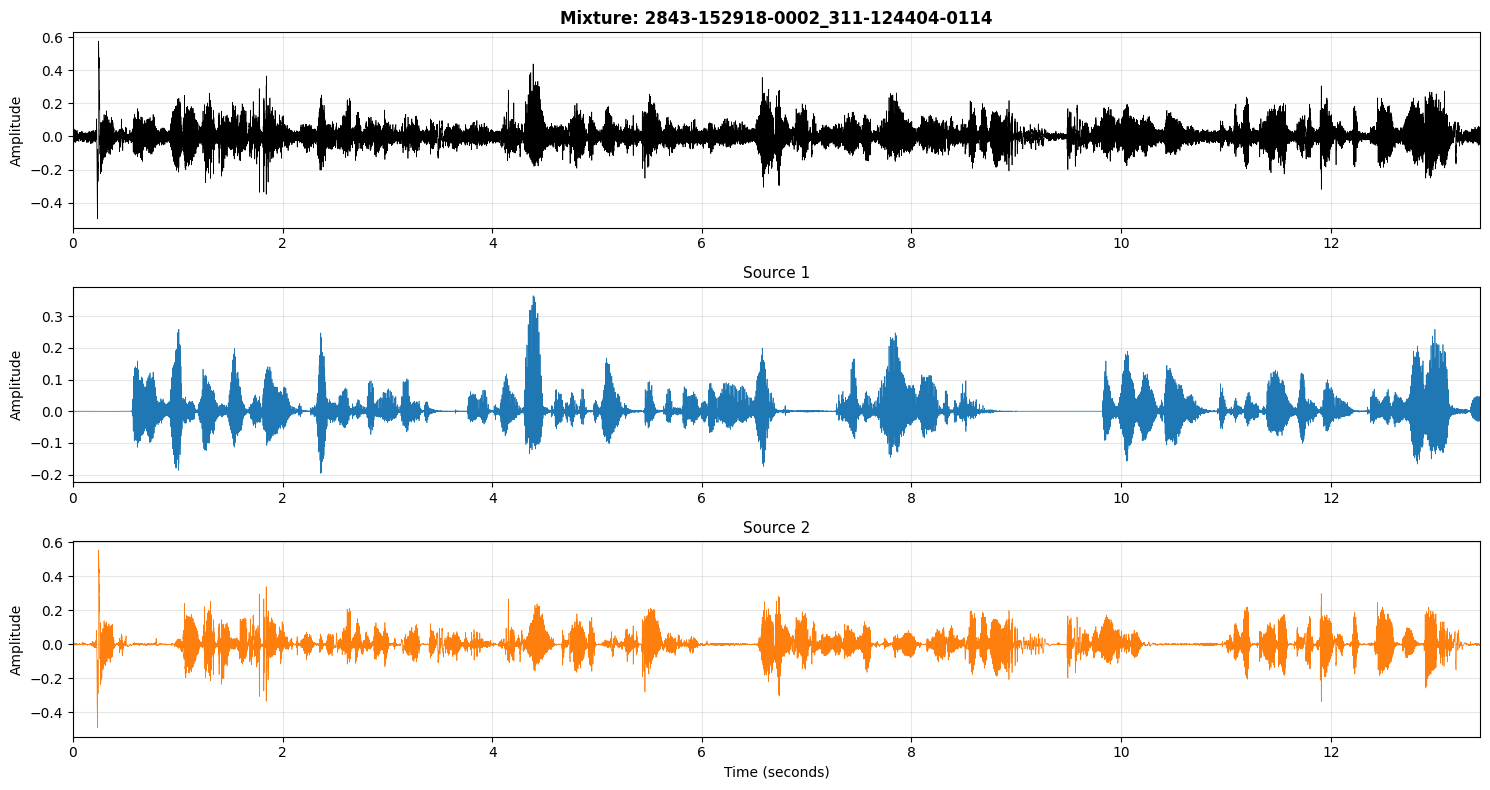


AUDIO:
Mixture:



Source 1:



Source 2:



Noise:




SAMPLE 2/3 (Index: 8646)
Sample ID: 3436-172171-0052_2843-152918-0078
Duration: 4.82 seconds
Average SNR: -0.95 dB
  Source 1: -1.84 dB
  Source 2: -0.07 dB
  Noise: -9.27 dB


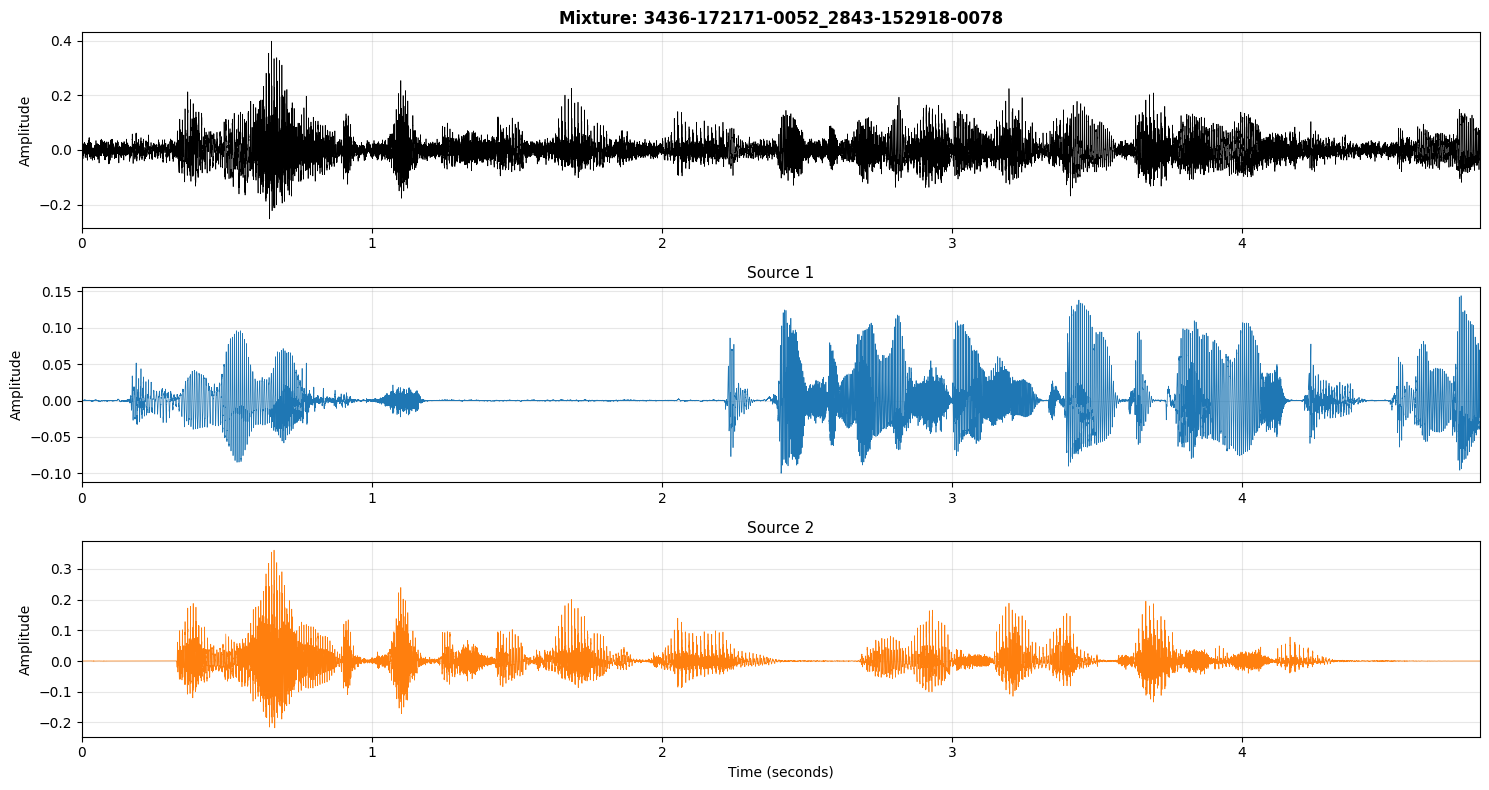


AUDIO:
Mixture:



Source 1:



Source 2:



Noise:




SAMPLE 3/3 (Index: 6783)
Sample ID: 1069-133699-0011_839-130898-0055
Duration: 14.74 seconds
Average SNR: -1.13 dB
  Source 1: -1.87 dB
  Source 2: -0.40 dB
  Noise: -8.29 dB


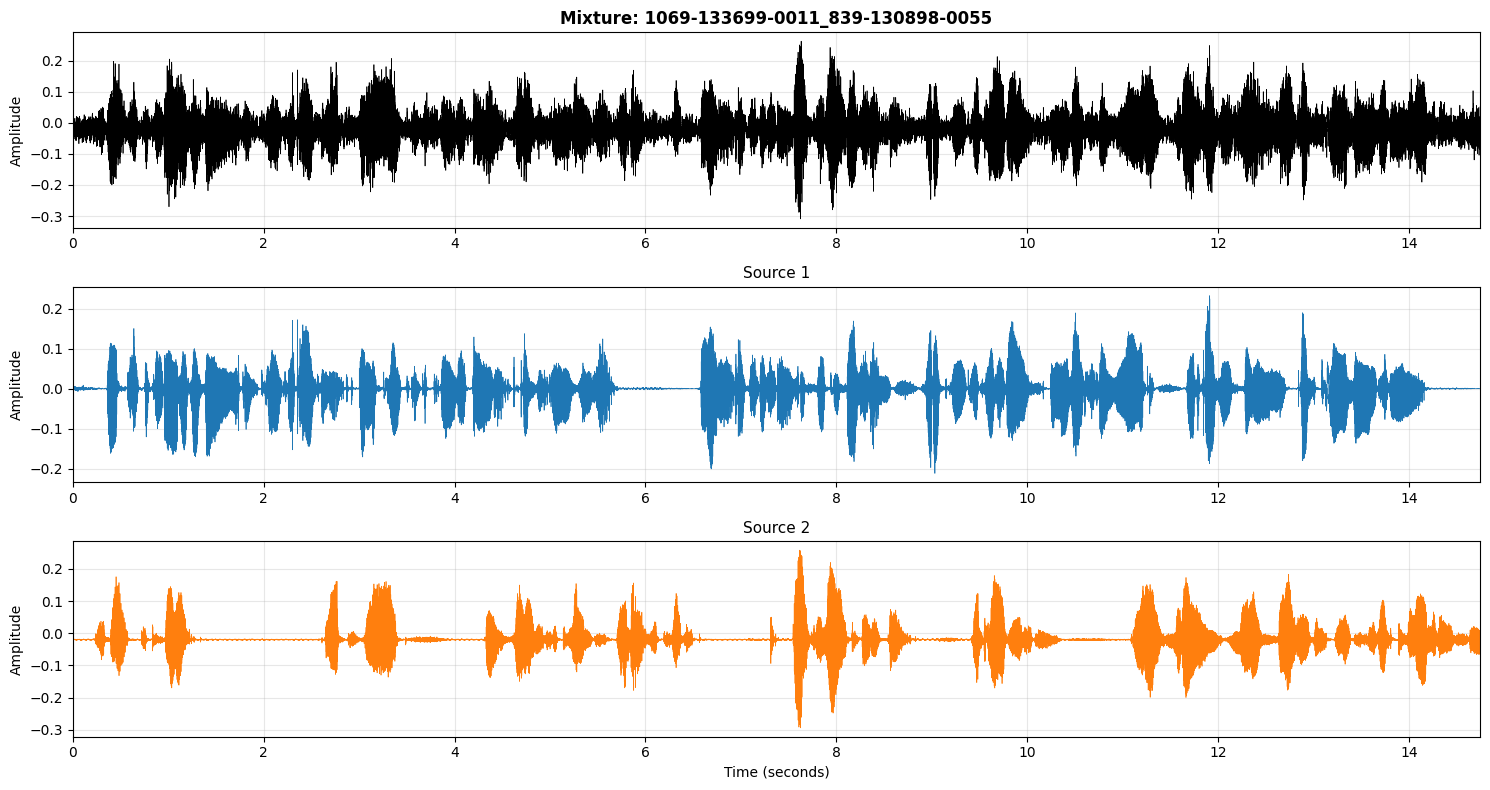


AUDIO:
Mixture:



Source 1:



Source 2:



Noise:


In [11]:
# VIEW RANDOM SAMPLES 
# CONFIGURATION
NUM_SAMPLES = 3 # how many random samples to display
PLAY_AUDIO = True # set to False to skip audio playback
seed = 0 # random seed

# get total number of samples
metadata_path = f"{ROOT_DIR}/wav{SAMPLE_RATE}/{MODE}/metadata/mixture_{SPLIT.replace('train', 'train-100')}_{MIXTURE_TYPE}.csv"
total_samples = len(pd.read_csv(metadata_path))

# generate random sample indices
np.random.seed(seed)
random_indices = np.random.choice(total_samples, size=NUM_SAMPLES, replace=False)

print(f"{'='*70}")
print(f"Viewing {NUM_SAMPLES} random samples from {SPLIT} set ({total_samples} total)")
print(f"{'='*70}\n")

for i, idx in enumerate(random_indices):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}/{NUM_SAMPLES} (Index: {idx})")
    print(f"{'='*70}")
    
    # load sample
    sample = load_sample(ROOT_DIR, SPLIT, MIXTURE_TYPE, idx, SAMPLE_RATE, N_SRC, MODE)
    
    print(f"Sample ID: {sample['mixture_id']}")
    print(f"Duration: {len(sample['mixture']) / sample['sample_rate']:.2f} seconds")
    
    # show SNR
    avg_snr = (sample['metrics']['source_1_snr'] + sample['metrics']['source_2_snr']) / 2
    print(f"Average SNR: {avg_snr:.2f} dB")
    
    print(f"  Source 1: {sample['metrics']['source_1_snr']:.2f} dB")
    print(f"  Source 2: {sample['metrics']['source_2_snr']:.2f} dB")
    if 'noise_snr' in sample['metrics']:
        print(f"  Noise: {sample['metrics']['noise_snr']:.2f} dB")
    
    # plot waveform
    time = np.arange(len(sample['mixture'])) / sample['sample_rate']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    
    # mixture
    axes[0].plot(time, sample['mixture'], linewidth=0.5, color='black')
    axes[0].set_title(f"Mixture: {sample['mixture_id']}", fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([0, time[-1]])
    
    # source 1
    axes[1].plot(time, sample['sources'][0], linewidth=0.5, color='C0')
    axes[1].set_title('Source 1', fontsize=11)
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim([0, time[-1]])
    
    # source 2
    axes[2].plot(time, sample['sources'][1], linewidth=0.5, color='C1')
    axes[2].set_title('Source 2', fontsize=11)
    axes[2].set_ylabel('Amplitude')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim([0, time[-1]])
    
    plt.tight_layout()
    plt.show()
    
    # play audio
    if PLAY_AUDIO:
        print("\nAUDIO:")
        print("Mixture:")
        display(Audio(sample['mixture'], rate=sample['sample_rate']))
        
        print("\nSource 1:")
        display(Audio(sample['sources'][0], rate=sample['sample_rate']))
        
        print("\nSource 2:")
        display(Audio(sample['sources'][1], rate=sample['sample_rate']))
        
        if 'noise' in sample:
            print("\nNoise:")
            display(Audio(sample['noise'], rate=sample['sample_rate']))
    
    print()